In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras import layers
import tensorflow as tf
from pathlib import Path
import os.path
import pandas as pd
import keras
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras import layers
from keras import regularizers

2024-05-24 12:42:12.981725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 12:42:12.981821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 12:42:13.156982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
strategy = tf.distribute.MirroredStrategy()

In [3]:
image_dir = Path('/age_data/UTKFace')
filepaths = pd.Series(list(image_dir.glob(r'*.jpg.chip.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(x)[-1].split('_')[0]), name='Age').astype(int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=100).reset_index(drop=True)
train_df, test_df = train_test_split(images, test_size = 0.1, random_state = 0)

In [4]:
print(images)

                                                Filepath  Age
0      /kaggle/input/utkface-new/UTKFace/32_0_3_20170...   32
1      /kaggle/input/utkface-new/UTKFace/67_1_0_20170...   67
2      /kaggle/input/utkface-new/UTKFace/30_0_4_20170...   30
3      /kaggle/input/utkface-new/UTKFace/24_1_4_20170...   24
4      /kaggle/input/utkface-new/UTKFace/42_0_1_20170...   42
...                                                  ...  ...
23702  /kaggle/input/utkface-new/UTKFace/54_1_0_20170...   54
23703  /kaggle/input/utkface-new/UTKFace/1_0_3_201612...    1
23704  /kaggle/input/utkface-new/UTKFace/35_1_2_20170...   35
23705  /kaggle/input/utkface-new/UTKFace/35_1_2_20170...   35
23706  /kaggle/input/utkface-new/UTKFace/61_0_0_20170...   61

[23707 rows x 2 columns]


In [5]:
image_size = (128,128)
batch = 256

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.1,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=image_size,
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch,
    shuffle=True,
    seed=42,
    subset='training',
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=image_size,
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch,
    shuffle=True,
    seed=42,
    subset='validation',
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch,
    shuffle=False
)


Found 19203 validated image filenames.
Found 2133 validated image filenames.
Found 2371 validated image filenames.


In [7]:
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', activity_regularizer=regularizers.L2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    epochs = 100
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='mae',
                metrics = ['mse'])

    callbacks = [keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        mode="auto",
        restore_best_weights=True,
        patience=5
    ),]

    model.summary()
    H = model.fit(
        train_images,
        validation_data=val_images,
        epochs=epochs,
        callbacks = callbacks,
        verbose = 1,
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - loss: 50.7955 - mse: 1488.8551 - val_loss: 19.3050 - val_mse: 491.7037
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - loss: 38.4964 - mse: 907.5892 - val_loss: 16.6763 - val_mse: 381.6724
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - loss: 32.3247 - mse: 674.2116 - val_loss: 15.2787 - val_mse: 297.4199
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 365ms/step - loss: 30.0859 - mse: 613.5245 - val_loss: 16.0245 - val_mse: 426.6022
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - loss: 29.3522 - mse: 600.1581 - val_loss: 13.3407 - val_mse: 226.4441
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 379ms/step - loss: 27.4137 - mse: 511.5488 - val_loss: 12.2603 - val_mse: 194.6291
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 392ms/step - loss: 25.5360 - mse: 454.8748 - val_loss: 11.5256 - val_mse: 182.6047
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - loss: 25.4285 - mse: 454.1318 - val_loss: 10.9665 - val_mse: 

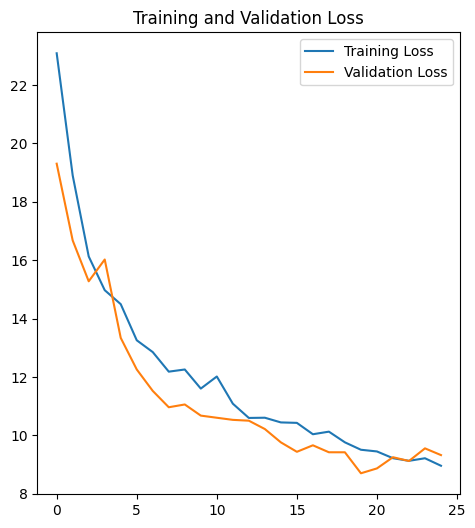

In [11]:
loss = H.history['loss']
val_loss = H.history['val_loss']

# Number of epochs
epochs_range = range(len(loss))

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [12]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Lưu trọng số của model vào tệp .h5
model.save_weights("model.weights.h5")

In [13]:
model.evaluate(test_images)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - loss: 17.2485 - mse: 226.7628


[8.860595703125, 121.25704956054688]